## Image_captioning 모델 로드후 테스트

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

In [2]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [3]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [4]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [5]:
max_length=52
units = 512
attention_features_shape = 64

In [6]:
def evaluate(image, encoder, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)
    hidden = tf.zeros((1, units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot



In [7]:
# Show original image(image), created words(result), (attention_plot) 
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image)) # load original image into array

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result) 
    for i in range(len_result): # show plot with each created words
        temp_att = np.resize(attention_plot[i], (8, 8)) # resize attention_plot
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(int(grid_size), int(grid_size), i + 1)
        ax.set_title(result[i]) # show each created word
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent()) # show original image with attention_plot

    plt.tight_layout()
    plt.show()

Prediction Caption: a puppy is standing next to the design <end>


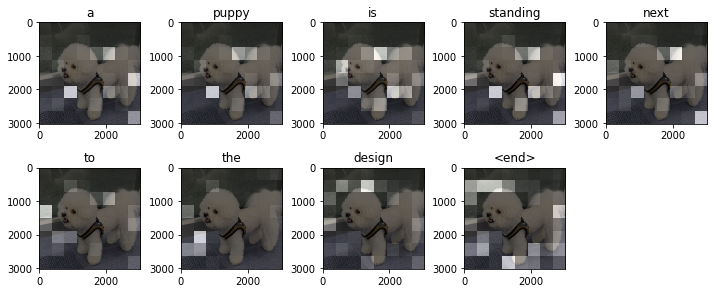

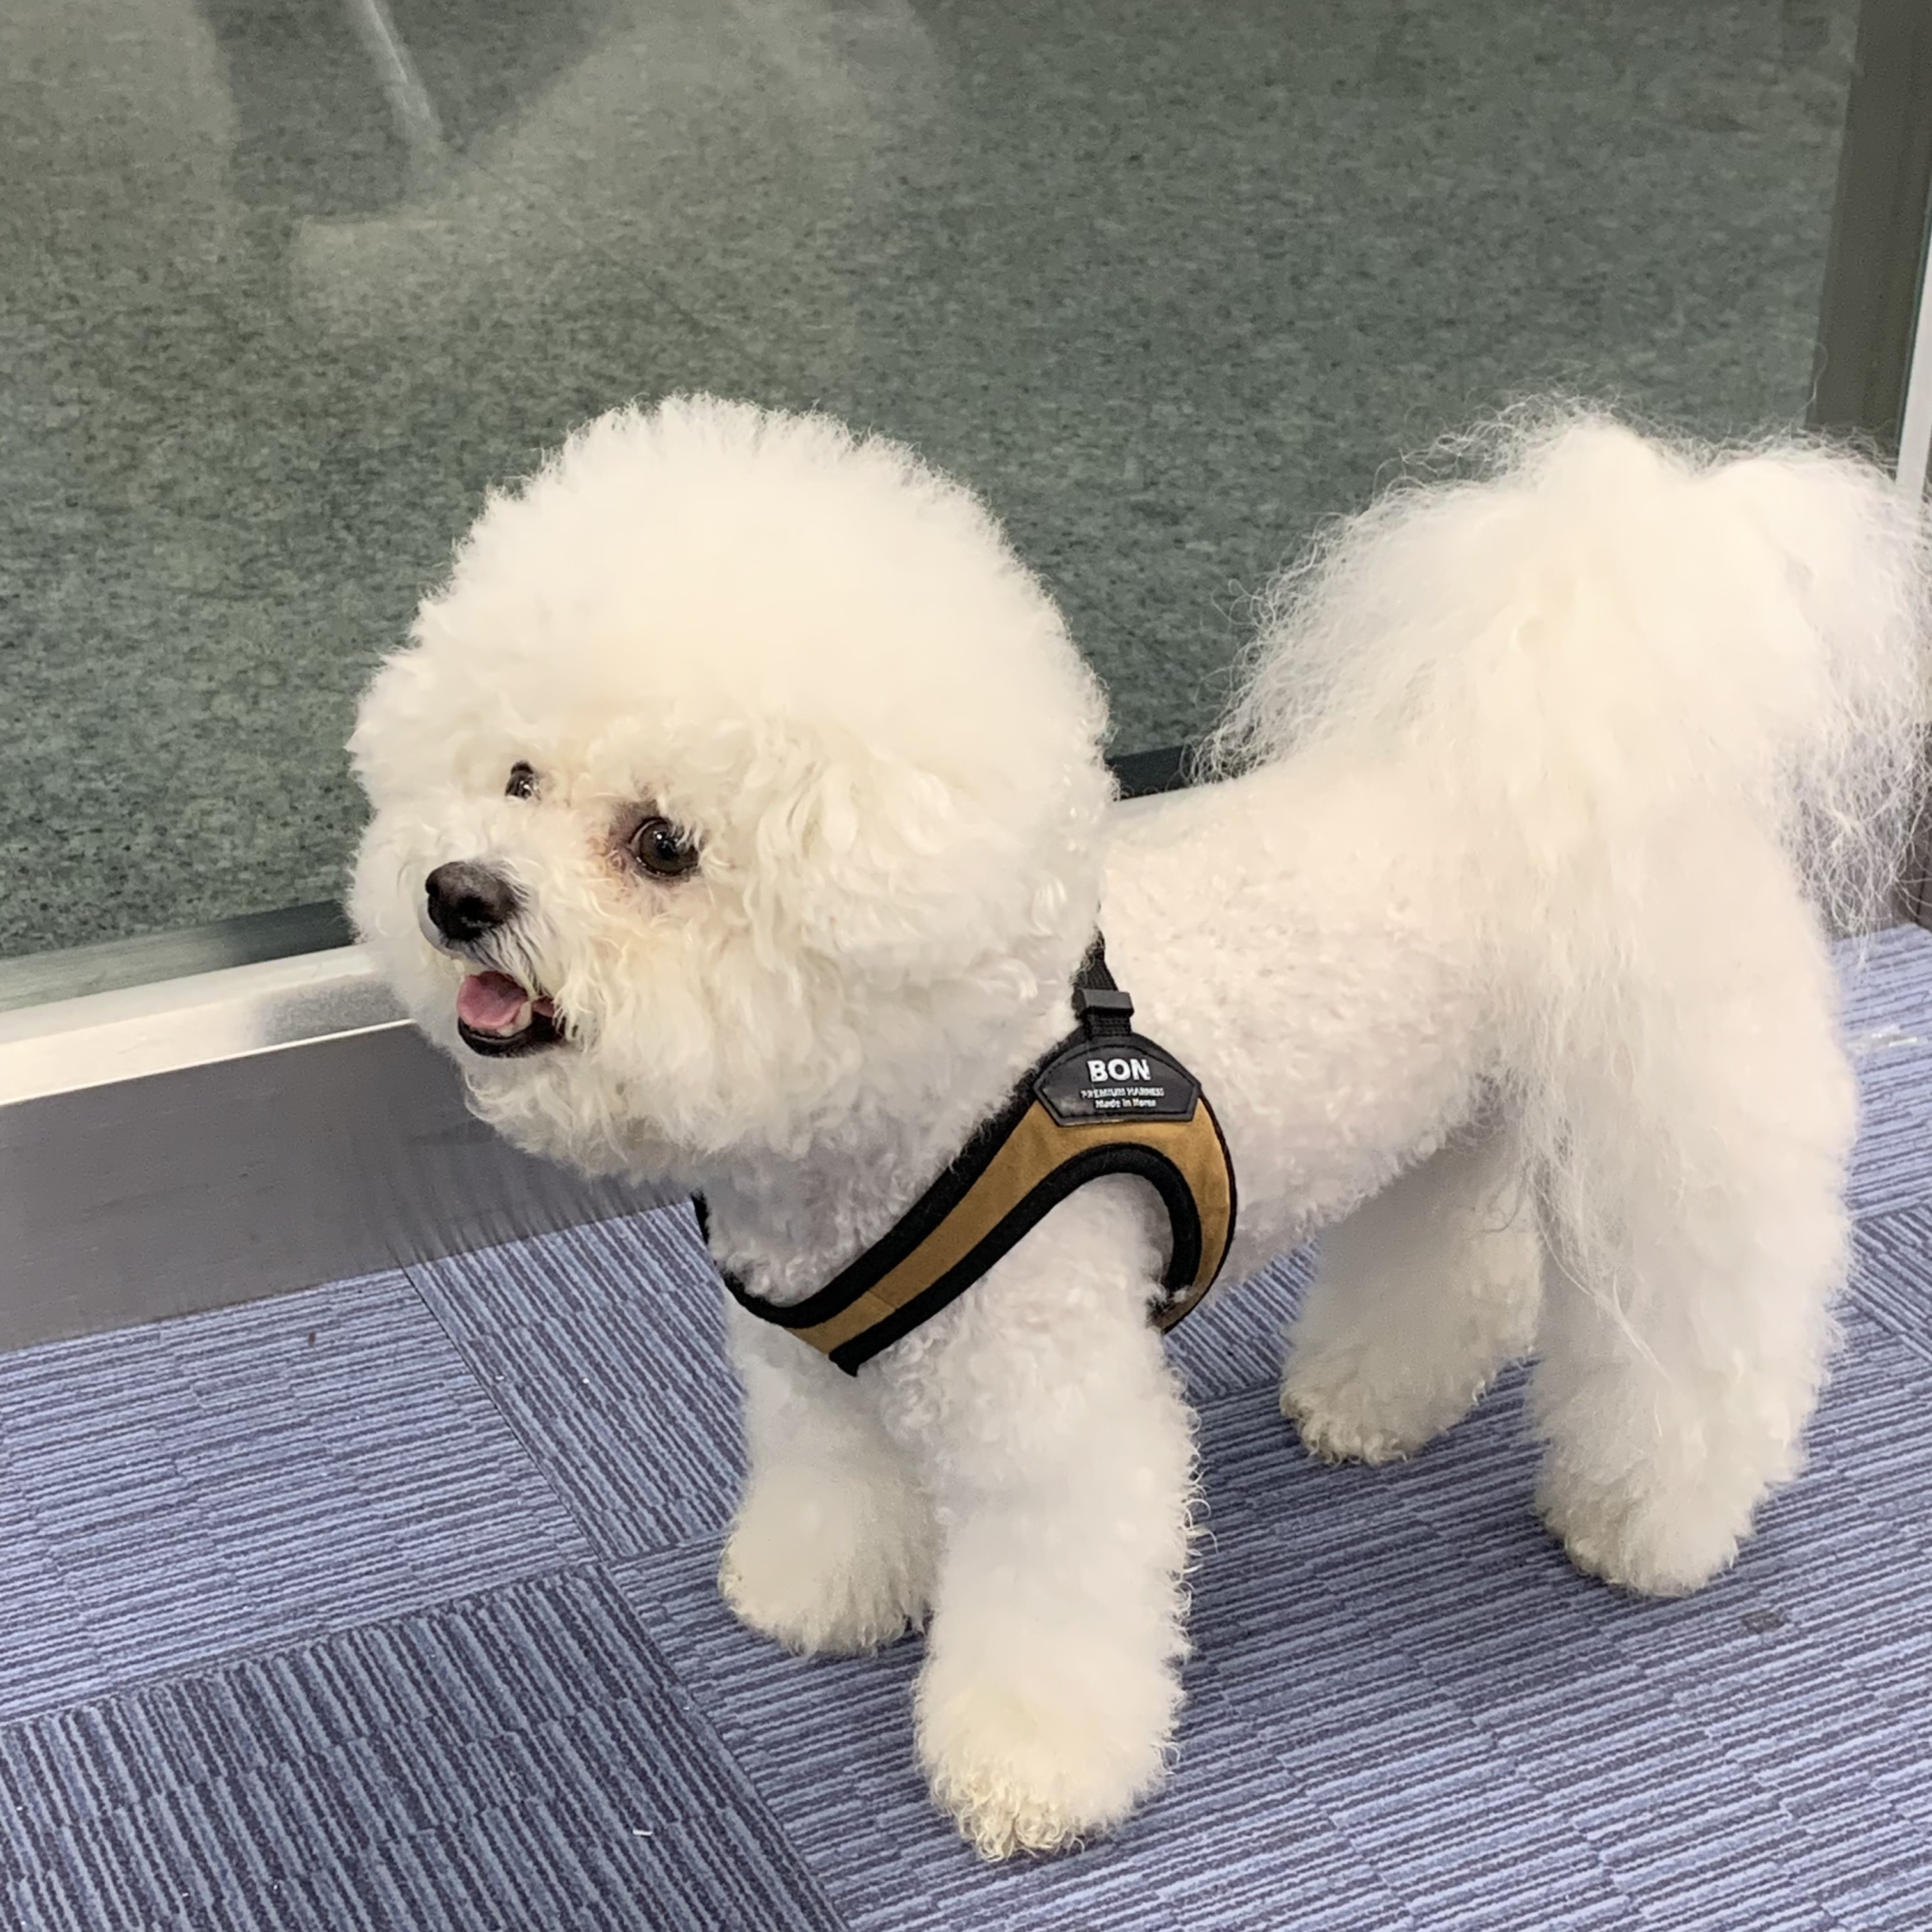

In [8]:
test_image_path = os.getcwd() + '.\\test_images\\jango.jpg' #test_images폴더 생성후 이미지 저장
# encoder_load = tf.keras.models.load_model('my_encoder')
# decoder_load = tf.keras.models.load_model('my_decoder'),
result, attention_plot = evaluate(
    test_image_path,
    encoder=tf.keras.models.load_model('my_encoder'),
    decoder=tf.keras.models.load_model('my_decoder'),
)
print('Prediction Caption:', ' '.join(result))
plot_attention(test_image_path, result, attention_plot)
Image.open(test_image_path)